<a href="https://colab.research.google.com/github/sthalles/computer-vision/blob/master/project-4/project-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)

In [0]:
# select the image id (valid values 1,2,3, or 4)
imageId = 1
feature_extractor = 'sift'
feature_matching = 'bf'

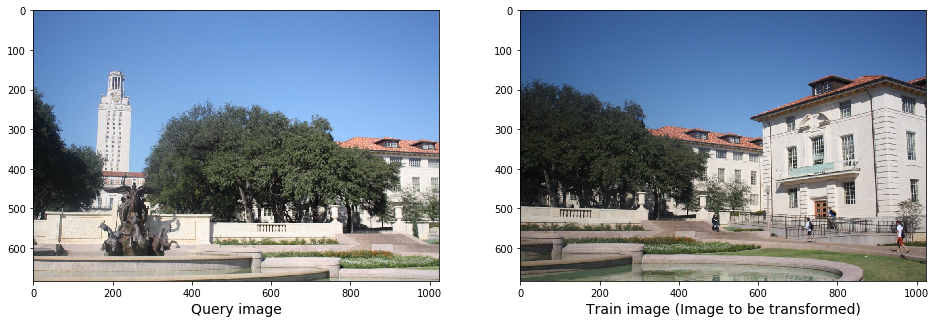

In [0]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
trainImg = cv2.imread('./input/foto' + str(imageId) + 'A.jpg')
trainImg = cv2.cvtColor(trainImg,cv2.COLOR_BGR2RGB)
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = cv2.imread('input/foto' + str(imageId) + 'B.jpg')
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg = cv2.cvtColor(queryImg,cv2.COLOR_BGR2RGB)
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.savefig("./output/input_img_"+str(imageId)+'.jpeg', bbox_inches='tight', dpi=300, optimize=True, format='jpeg')

plt.show()

In [0]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [0]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

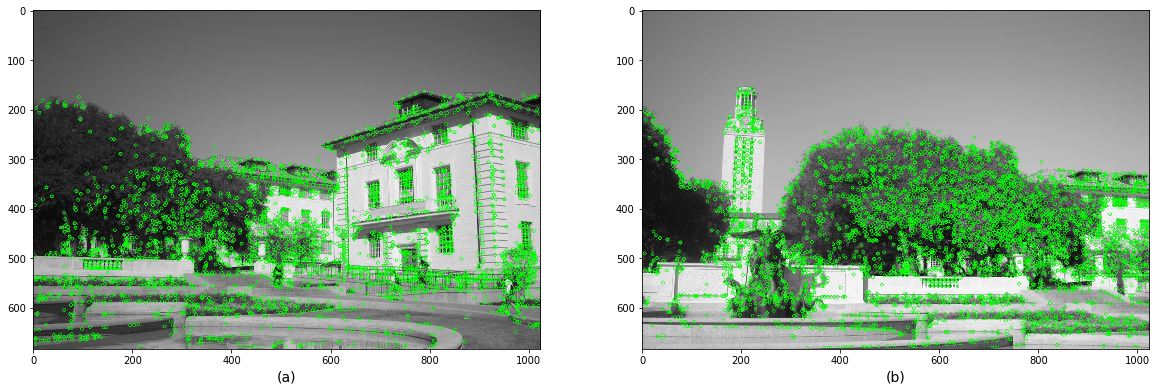

In [0]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.savefig("./output/" + feature_extractor + "_features_img_"+str(imageId)+'.jpeg', bbox_inches='tight', 
            dpi=300, optimize=True, format='jpeg')
plt.show()

In [0]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [0]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort them in the order of their distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [0]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 2634


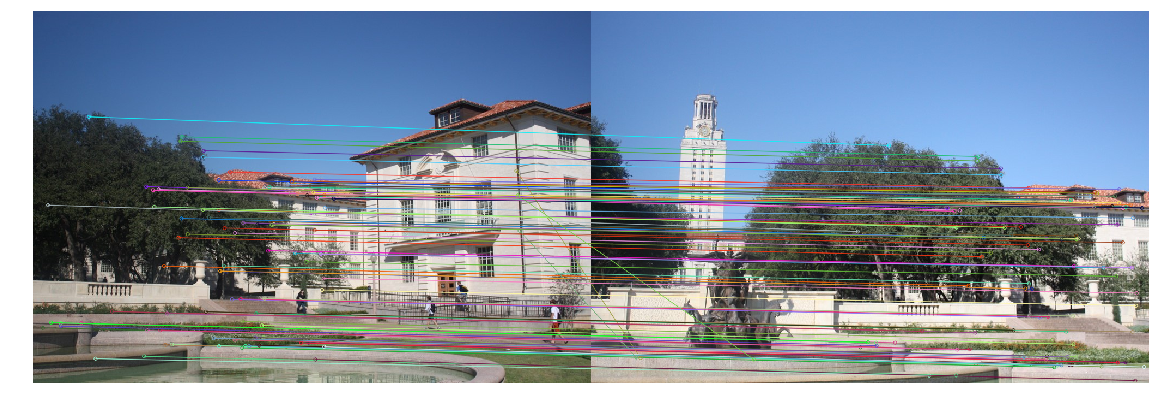

In [0]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.axis('off')
plt.savefig("./output/" + feature_matching + "_matching_img_"+str(imageId)+'.jpeg', bbox_inches='tight', 
            dpi=300, optimize=True, format='jpeg')
plt.show()

In [0]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints from KeyPoint objects to NumPy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # compute the homography between the two sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        # return the matches along with the homograpy matrix
        # and status of each matched point
        return (matches, H, status)
    else:
        return None

In [0]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 7.66380921e-01  3.65186796e-02  4.46627996e+02]
 [-1.35000633e-01  9.11358967e-01  7.61410429e+01]
 [-2.10164883e-04 -3.32000479e-05  1.00000000e+00]]


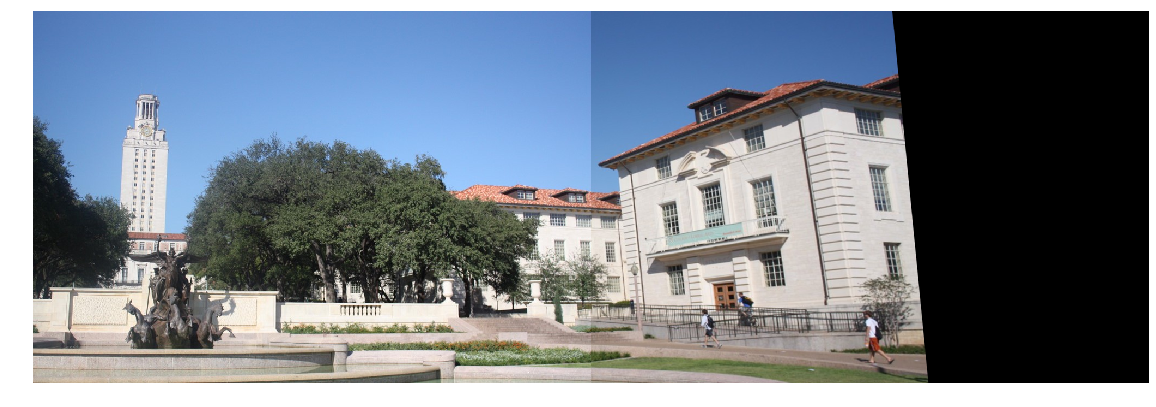

In [0]:
# Apply a horizontal panorama
width = queryImg.shape[1] + trainImg.shape[1]
height = max(queryImg.shape[0], trainImg.shape[0])
# otherwise, apply a perspective warp to stitch the images
# together
(matches, H, status) = M
result = cv2.warpPerspective(trainImg, H,
    (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)

imageio.imwrite("./output/horizontal_panorama_img_"+str(imageId)+'.jpeg', result)
plt.show()

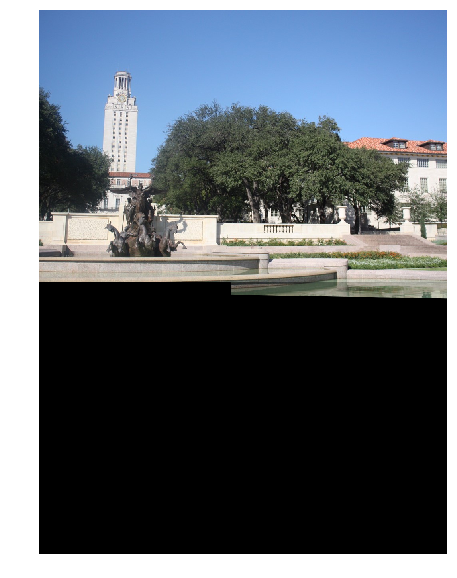

In [0]:
# Apply a vertical panorama
width = max(trainImg.shape[1], queryImg.shape[1])
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], :] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

imageio.imwrite("./output/vertical_panorama_img_"+str(imageId)+'.jpeg', result)

plt.axis('off')
plt.show()